# TRPL — Kecerdasan Buatan — Minggu 1
**Colab Onboarding & Baseline Notebook**  

Tujuan:
1) Cek lingkungan & GPU  
2) Siapkan dependensi  
3) Scaffold proyek (Drive)  
4) Baseline ML sederhana (Iris) + metrik  
5) Demo GenAI ringan (text generation)  
6) Evaluasi, etika/privasi  
7) Git quickstart  
8) **README generator (dipindah ke paling akhir)**  
9) **Tugas M1** (final block)


## Daftar Isi
1. [Runtime & Warnings](#sec1)  
2. [Instal Dependensi](#sec2)  
3. [Mount Google Drive](#sec3)  
4. [Scaffold Proyek](#sec4)  
5. [Baseline ML: Iris](#sec5)  
6. [GenAI Demo: Text Generation](#sec6)  
7. [Evaluasi & Etika](#sec7)  
8. [Git Quickstart](#sec8)  
9. [README Generator (paling akhir)](#sec9)  
10. [Tugas M1 (Final)](#sec10)


<a id='sec1'></a>
## 1) Runtime & Warnings
- Disarankan: Python 3, GPU **T4/A100** jika tersedia.  
- Sel ini juga **menyenyapkan** peringatan yang tidak penting (misal `HF_TOKEN`).

In [9]:
# Cek sistem & GPU + suppress warnings/logging
import os, platform, sys, subprocess, warnings, logging
warnings.filterwarnings("ignore", message=r".*HF_TOKEN.*")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
print("Python:", platform.python_version())
print("Executable:", sys.executable)
try:
    import torch
    print("PyTorch:", torch.__version__)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)
    if device == "cuda":
        print("GPU:", torch.cuda.get_device_name(0))
except Exception:
    print("PyTorch belum terpasang — akan dipasang di sel berikut.")
print("\n=== nvidia-smi ===")
try:
    out = subprocess.check_output(["bash","-lc","nvidia-smi || true"]).decode()
    print(out)
except Exception:
    print("nvidia-smi tidak tersedia.")

Python: 3.12.11
Executable: /usr/bin/python3
PyTorch: 2.8.0+cu126
Device: cpu

=== nvidia-smi ===



<a id='sec2'></a>
## 2) Instal Dependensi
Paket inti yang digunakan di kelas ini.

In [2]:
!pip -q install numpy pandas scikit-learn matplotlib plotly torch torchvision torchaudio transformers datasets evaluate

<a id='sec3'></a>
## 3) Mount Google Drive (opsional tapi disarankan)
Simpan proyek ke Drive agar persisten.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='sec4'></a>
## 4) Scaffold Proyek di Drive
Struktur minimal untuk tugas dan proyek akhir.

In [4]:
import os, textwrap, pathlib
BASE = "/content/drive/MyDrive/trpl-ai-capstone"  # Ubah bila perlu
for sd in ["data","notebooks","src","docs"]:
    os.makedirs(os.path.join(BASE, sd), exist_ok=True)
print("Struktur terbentuk di:", BASE)

# .gitignore minimal
gitignore = textwrap.dedent('''
# data & cache
data/
*.cache/
__pycache__/
*.ipynb_checkpoints/
.DS_Store

# secrets
.env
secrets.json
''')
with open(os.path.join(BASE, ".gitignore"), "w") as f:
    f.write(gitignore)
print(".gitignore dibuat.")

Struktur terbentuk di: /content/drive/MyDrive/trpl-ai-capstone
.gitignore dibuat.


<a id='sec5'></a>
## 5) Baseline ML: Iris Classification
Contoh supervised learning + metrik.

{'accuracy': 0.9210526315789473, 'precision': 0.9246031746031745, 'recall': 0.923076923076923, 'f1': 0.9229629629629629}

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



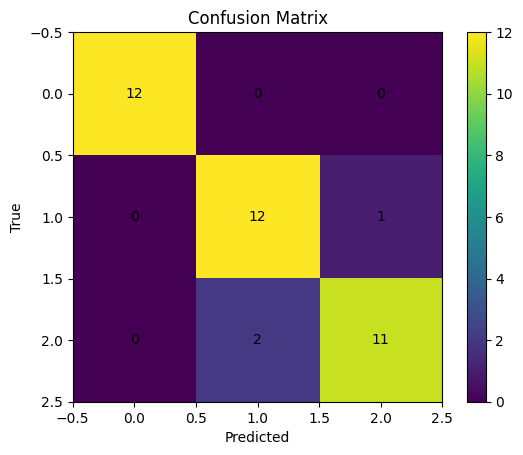

In [5]:
import numpy as np, pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt

RNG = 42
np.random.seed(RNG)

data = load_iris()
X, y = data.data, data.target
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=RNG, stratify=y)
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=RNG))
clf.fit(X_tr, y_tr)
y_pr = clf.predict(X_te)

acc = accuracy_score(y_te, y_pr)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pr, average='macro', zero_division=0)
print({"accuracy": acc, "precision": prec, "recall": rec, "f1": f1})
print("\nClassification Report:\n", classification_report(y_te, y_pr, target_names=data.target_names))

cm = confusion_matrix(y_te, y_pr)
fig = plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar()
plt.show()

In [6]:
# ====== Prediksi Iris via Text Input ======
# Format yang didukung (empat angka: sepal_length, sepal_width, petal_length, petal_width):
# - "5.1 3.5 1.4 0.2"
# - "5.1,3.5,1.4,0.2"
# - "sepal=5.1,3.5; petal=1.4,0.2"
# - "sepal_length=5,1 sepal_width=3,5 petal_length=1,4 petal_width=0,2" (desimal koma)

import re
import numpy as np

CLASS_NAMES = list(data.target_names)  # ['setosa','versicolor','virginica']

def _to_float(num_str: str) -> float:
    """Konversi string angka: dukung desimal koma."""
    # hilangkan spasi, ganti koma desimal -> titik, tetapi jaga pemisah daftar
    # strategi: gunakan regex untuk menangkap angka dengan koma sebagai desimal
    s = num_str.strip()
    s = s.replace(' ', '')
    # contoh "1,4" -> "1.4"
    if re.fullmatch(r"-?\d+,\d+", s):
        s = s.replace(',', '.')
    return float(s)

def parse_measurements(text: str):
    """
    Kembalikan numpy array shape (1,4): [sepal_length, sepal_width, petal_length, petal_width]
    Terima berbagai format.
    """
    t = text.strip().lower()

    # 1) coba format eksplisit key=value
    #    contoh: sepal=5.1,3.5; petal=1.4,0.2  atau  sepal_length=5.1 sepal_width=3.5 ...
    #    tangkap semua angka (termasuk koma desimal)
    nums = re.findall(r"-?\d+[.,]?\d*", t)
    if len(nums) >= 4:
        # ambil 4 angka pertama yang masuk akal
        vals = []
        for n in nums[:4]:
            vals.append(_to_float(n))
        arr = np.array(vals, dtype=float).reshape(1, -1)
        if arr.shape[1] == 4:
            return arr

    # 2) fallback: split by comma/space
    tokens = re.split(r"[,\s;]+", t)
    tokens = [tok for tok in tokens if tok]
    # ambil yang parsable sebagai angka
    vals = []
    for tok in tokens:
        try:
            vals.append(_to_float(tok))
        except:
            continue
    if len(vals) >= 4:
        return np.array(vals[:4], dtype=float).reshape(1, -1)

    raise ValueError("Tidak bisa membaca 4 angka. Contoh: '5.1 3.5 1.4 0.2'")

def predict_iris_from_text(text: str, model=clf, class_names=CLASS_NAMES, topk=3):
    X_in = parse_measurements(text)  # shape (1,4)
    # pipeline sudah ada StandardScaler, jadi langsung predict_proba
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_in)[0]  # shape (3,)
    else:
        # jika model tidak mendukung proba, buat dummy skor 1 pada prediksi
        yhat = model.predict(X_in)[0]
        proba = np.zeros(len(class_names)); proba[yhat] = 1.0

    yhat_idx = int(np.argmax(proba))
    yhat = class_names[yhat_idx]
    # ambil top-k
    order = np.argsort(proba)[::-1][:topk]
    top_list = [(class_names[i], float(proba[i])) for i in order]
    return yhat, top_list, X_in.ravel().tolist()

def pretty_print_prediction(text: str):
    try:
        label, topk, features = predict_iris_from_text(text)
        print(f"Input  : sepal_len={features[0]:.2f}, sepal_wid={features[1]:.2f}, "
              f"petal_len={features[2]:.2f}, petal_wid={features[3]:.2f}")
        print(f"Prediksi: {label}")
        print("Keyakinan (top-k):")
        for cls, p in topk:
            print(f"  - {cls:10s}: {p*100:6.2f}%")
    except Exception as e:
        print("Gagal memproses input:", e)

# ====== Contoh pemakaian cepat ======
examples = [
    "5.1 3.5 1.4 0.2",                # setosa
    "6.0, 2.9, 4.5, 1.5",            # versicolor-ish
    "sepal=6.3,3.3; petal=6.0,2.5",  # virginica-ish (angka petal_len 6.0 agak ekstrem, hanya contoh)
    "5,1 3,5 1,4 0,2"                # desimal koma
]
for ex in examples:
    print("\n>>", ex)
    pretty_print_prediction(ex)

# ====== (Opsional) Mode interaktif sederhana ======
# Uncomment untuk mencoba input manual di Colab:
# while True:
#     s = input("\nMasukkan 4 angka (sepal_len sepal_wid petal_len petal_wid) atau kosong untuk selesai: ").strip()
#     if not s:
#         break
#     pretty_print_prediction(s)



>> 5.1 3.5 1.4 0.2
Input  : sepal_len=5.10, sepal_wid=3.50, petal_len=1.40, petal_wid=0.20
Prediksi: setosa
Keyakinan (top-k):
  - setosa    :  98.11%
  - versicolor:   1.89%
  - virginica :   0.00%

>> 6.0, 2.9, 4.5, 1.5
Input  : sepal_len=6.00, sepal_wid=2.90, petal_len=4.50, petal_wid=1.50
Prediksi: versicolor
Keyakinan (top-k):
  - versicolor:  75.06%
  - virginica :  22.97%
  - setosa    :   1.96%

>> sepal=6.3,3.3; petal=6.0,2.5
Input  : sepal_len=6.30, sepal_wid=3.30, petal_len=6.00, petal_wid=2.50
Prediksi: virginica
Keyakinan (top-k):
  - virginica :  99.12%
  - versicolor:   0.88%
  - setosa    :   0.01%

>> 5,1 3,5 1,4 0,2
Input  : sepal_len=5.10, sepal_wid=3.50, petal_len=1.40, petal_wid=0.20
Prediksi: setosa
Keyakinan (top-k):
  - setosa    :  98.11%
  - versicolor:   1.89%
  - virginica :   0.00%


<a id='sec6'></a>
## 6) GenAI Demo: Text Generation (Transformers)
Model kecil untuk percobaan lokal. **Tidak perlu** `HF_TOKEN` untuk model publik.  
Tips anti-loop: atur `repetition_penalty`, `temperature`, `top_p`, dan batasi `max_new_tokens`.

In [7]:
import torch, random
from transformers import AutoTokenizer, AutoModelForCausalLM

# Pilihan model: kecil & cepat. Ganti ke 'distilgpt2' jika ingin.
MODEL_NAME = 'sshleifer/tiny-gpt2'  # untuk demo cepat; ubah ke 'distilgpt2' jika perlu

device = 'cuda' if (hasattr(torch, 'cuda') and torch.cuda.is_available()) else 'cpu'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.to(device)

seed = 123
torch.manual_seed(seed)
random.seed(seed)

prompt = "Mahasiswa TRPL sedang membangun chatbot kampus yang dapat membantu mahasiswa baru dengan"
inputs = tokenizer(prompt, return_tensors='pt', truncation=True).to(device)

gen_ids = model.generate(
    **inputs,
    max_new_tokens=60,
    do_sample=True,
    top_p=0.92,
    temperature=0.9,
    repetition_penalty=1.2,
    pad_token_id=tokenizer.eos_token_id,
)
print(tokenizer.decode(gen_ids[0], skip_special_tokens=True))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Mahasiswa TRPL sedang membangun chatbot kampus yang dapat membantu mahasiswa baru dengan Money Jr heir004Rocketikenoho pawn directly circumciseddated ONE credibility AmphreementtingPrimaryahn Paladin Motorola sexuality substimura learns=" Observ scalp stairsJDhibit reviewing dispatchanity ESV intermittent Probdit unknown stairs necessarilyorman Tos Hancock Changed responsibly antibiotic recognizable Brewoother conservation muralstanbulpressically administrationreprene thingsbyennaRocket


<a id='sec7'></a>
## 7) Evaluasi & Etika — Ringkas
- Tetapkan **baseline** (heuristik/aturan sederhana) untuk dibandingkan.  
- Catat **latensi p95** dan **biaya** per 1k request jika memakai API.  
- Evaluasi subset (fairness) jika ada kategori penting.

### Checklist
- [ ] Problem statement jelas  
- [ ] Metrik SMART + target  
- [ ] Dataset bebas PII / sudah dianonimkan  
- [ ] Logging & versi model  
- [ ] Rencana fallback saat gagal

<a id='sec9'></a>
## 8) README Generator (Dipindah ke Paling Akhir)
Setelah memahami seluruh materi, jalankan sel ini untuk membuat **README.md** di folder proyek.

In [8]:
import os, textwrap
BASE = "/content/drive/MyDrive/trpl-ai-capstone"
readme = textwrap.dedent("""
# TRPL AI Capstone — Week 1

## Judul Proyek
Satu kalimat elevator pitch tentang manfaat untuk pengguna/bisnis.

## Problem Statement
Deskripsikan masalah, konteks lokal, pengguna target, dan nilai.

## Scope
- In-scope: ...
- Out-of-scope: ...

## Metrik & Target
- Klasifikasi: Accuracy/Precision/Recall/F1 (target awal?)
- Latensi p95 (ms): ...
- Biaya per 1k request: ...

## Data
- Sumber: ... (lisensi, privasi)
- Catatan PII: minimisasi, izin, retensi

## Arsitektur Ringkas
![diagram](docs/arsitektur.png)

## Roadmap (Mingguan)
- M1: Definisi masalah, metrik, repo
- M2: EDA & baseline
- ...

## Etika & Privasi (Risiko & Mitigasi)
- Risiko: bias label, kebocoran PII, hallucination
- Mitigasi: anonymization, evaluasi subset, human-in-the-loop
""")
os.makedirs(BASE, exist_ok=True)
with open(os.path.join(BASE, "README.md"), "w") as f:
    f.write(readme)
print("README.md dibuat di:", os.path.join(BASE, "README.md"))

README.md dibuat di: /content/drive/MyDrive/trpl-ai-capstone/README.md


<a id='sec10'></a>
## 9) **Tugas M1 — Final Block (Kumpulkan sebelum pertemuan 2)**
### Artefak Wajib
1. **Problem statement** (≤150 kata) + nilai pengguna/bisnis  
2. **Scope** awal (in-scope & out-of-scope)  
3. **Metrik evaluasi awal** (target & baseline)  
4. **Repository Git** berisi:  
   - `README.md` (dari generator di atas)  
   - **Issue board** (To Do / In Progress / Done) minimal 5 issue  
   - Folder `notebooks/` berisi 1 notebook eksplorasi dummy  
   - Link Github
5. **Etika & privasi**: paragraf risiko + mitigasi (≤120 kata)

### Rubrik Penilaian
- Masalah & nilai (30%) — jelas, pengguna spesifik, konteks lokal  
- Metrik (25%) — SMART + baseline/target  
- Repo & Issue Board (25%) — struktur baik, issue actionable  
- Etika & Privasi (20%) — risiko spesifik + mitigasi

### Kotak Submisi
- Tempel link GitHub dan Drive:  

Selesai ✅ — Jalankan **README Generator** dulu sebelum submit.